In [ ]:
#%matplotlib notebook

In [1]:
import time

import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from skimage.filters import gaussian

import math

from datetime import date

from glob import glob
from scipy import ndimage
from skimage import img_as_float, io
import imageio
import json

## Overview

This code is used to take a large image and then split it into individual components which will be processed separately (stardist), and then stitch them back together afterwards to form a processed version of the original. Ideally, the raw image file, the grid overlaid image, as well as the post-processed image will all be retained.

The steps to achieve this are as follows:

1. Input image


2. Image slicer
    - overlay a grid, with overlapping cells
    - create subimages based on cell coordinates
    - save subimages to a created folder on disk
    - save coordinates of subimages that will be serialized into a json file in the same folder
    
    
3. Process subimage tiles
    - stardist segmentation


4. Reconstruct processed version of original image
    - separate file from raw original


5. Output should be the original image, the subimage tiles, and the post-processed construct

Object segmentation through stardist is computationally expensive and has an upper limit on image file size, so by breaking the original into more manageable subimages, this should mitigate the issue.

## Code mechanics

We begin by pulling information about the dimensions of the image using `.shape`:

```
sample.shape
(21504, 19558)
```
Then set up our parameters:

```
tile_step = 2000
tile_size = 2048

```

- `tile_step` is the increment along the x and y axis which will determine the size of the overall grid

- `tile_size` is the size of individual grid cells
Note that the `tile_size` is larger than `tile_step` (2048 vs. 2000), thus causing overlaps from tile to tile. This is intentional to accomodate for objects that are split along gridlines. The overlaps serve as a buffer zone so that split objects can be stitched together later.

We calculate how many tiles will fit across the length and width of the image:

```
length = math.ceil(sample.shape[0]/tile_step)
width = math.ceil(sample.shape[1]/tile_step)
print(length)
print(width)

11
10
```

### Setting up the loop

```
tile_range_r = np.arange(0, sample.shape[0]+tile_size, tile_step)
tile_range_c = np.arange(0, sample.shape[1]+tile_size, tile_step)
```

- `tile_range` consists of values from 0 to the ceiling of `shape` values + `tile_size`, in increments of `tile_step`, effectively a list of row/column length. The addition of one increment of `tile_size` to the `shape` value ensures that the range fully covers the size of the image being processed. The overhang is negligible as it will not affect the creation of a grid.

---
Using our current values, our outputs are:
```
tile_range_r
[0, 2000, 4000, 8000, 10000, 12000, 14000, 16000, 18000, 20000, 22000]

tile_range_c
[0, 2000, 4000, 8000, 10000, 12000, 14000, 16000, 18000, 20000]
```

---

### Integrating meshgrid

```
xs, ys = np.meshgrid(tile_range_r, tile_range_c)
```

`meshgrid` is a method where a cartesian grid is generated given certain parameters. In this case, our grid is composed of coordinates given by `tile_range_r` as our "x" values, and `tile_range_c` our "y" values 

## Issues

- There is currently an indexing issue with the for loop, as the y-axis is being clipped prematurely. I suspect that this is because of step sizes and rounding issues when assigning values to the tile_range variable.
    - The maximum values for each listed range is the nearest multiple of 2000 below the actual value.
    - Indexing issue has been mitigated by adding the `tile_size` to the `shape` value when calculating x and y ranges


- indexing issue with filename generation
    - fixed by replacing `elif` statements with the `zfill` method

- issue with capturing edge coordinates up to true shape values
    - fixed by changing indexing mode in meshgrid from cartesian to matrix
    
- image slicing of the `for` loop is incomplete
    - some images are not properly displayed, which could mean that the subimage generation is not properly executing
    - it may be an issue with the nested portion of the `for` loop

In [2]:
#if on laptop
sample = img_as_float(io.imread('C:/Users/jv92c/Documents/mFISH/sample_data/DAPI_Overview_cropped.tif'))

In [2]:
#if at office machine
sample = img_as_float(io.imread('C:/Users/john.villanueva/Documents/sample_data/DAPI_Overview.tif'))

In [3]:
today = date.today()
sample.shape

(11248, 5856)

In [4]:
#slice intervals
tile_step = 2000

#size of the 2D slice
#also determines the overlap between FOVs for use in stitching of edge objects
tile_size = 2048

In [5]:
length = math.ceil(sample.shape[0]/tile_step)
width = math.ceil(sample.shape[1]/tile_step)

print(length)
print(width)

6
3


In [10]:
#range in the x-direction determined by width of image; row length
tile_range_r = np.arange(0, sample.shape[1]+tile_size, tile_step)

#range in the y-direction determined by height; column height
tile_range_c = np.arange(0, sample.shape[0]+tile_size, tile_step)

xs, ys = np.meshgrid(tile_range_r, tile_range_c, indexing='ij')

In [12]:
ys

array([[    0,  2000,  4000,  6000,  8000, 10000, 12000],
       [    0,  2000,  4000,  6000,  8000, 10000, 12000],
       [    0,  2000,  4000,  6000,  8000, 10000, 12000],
       [    0,  2000,  4000,  6000,  8000, 10000, 12000]])

C:\Users\jv92c\Anaconda3\envs\stardist\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
C:\Users\jv92c\Anaconda3\envs\stardist\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\jv92c\Anaconda3\envs\stardist\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


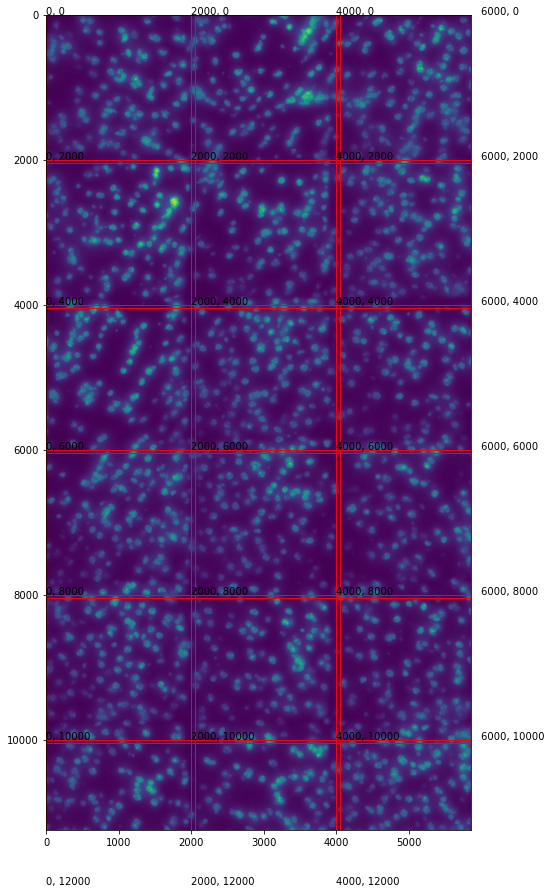

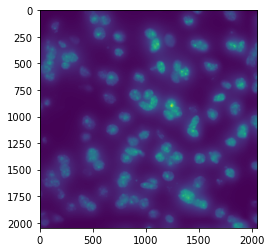

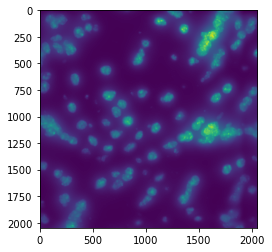

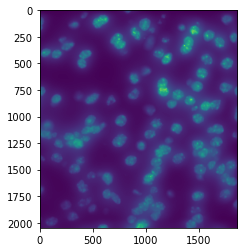

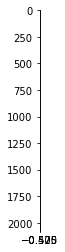

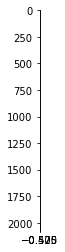

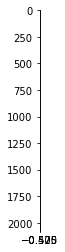

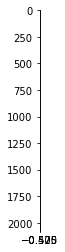

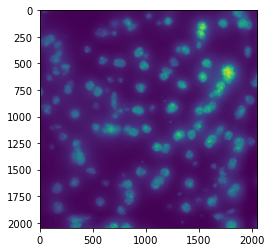

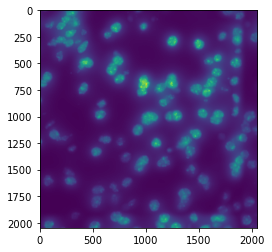

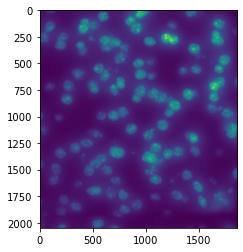

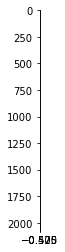

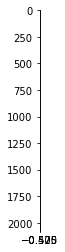

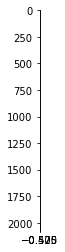

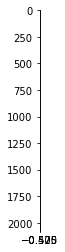

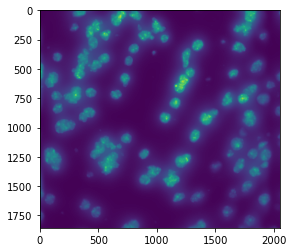

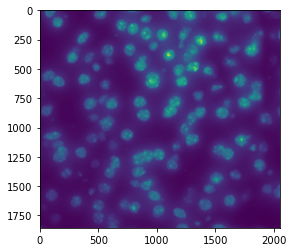

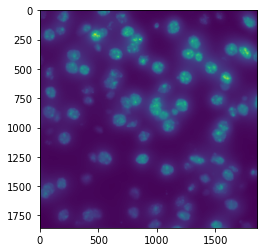

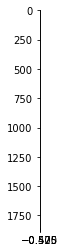

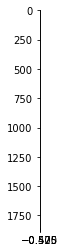

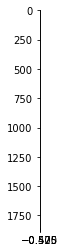

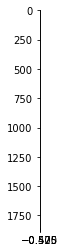

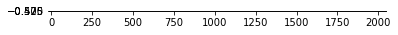

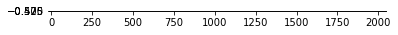

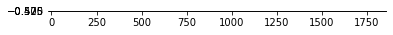

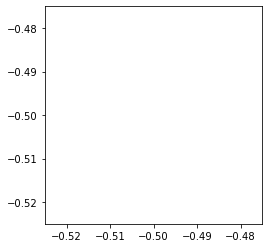

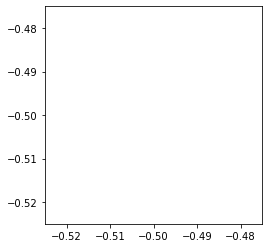

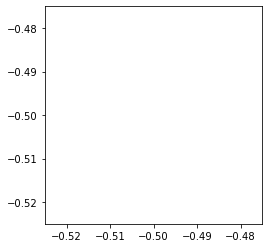

In [16]:
plt.figure(figsize= [15,15])
plt.imshow(sample)
ax = plt.gca()

img_dir = []
img_coordinates = []
img_pos = {}

for ii, tile in enumerate(xs.ravel()):
    
    #this is to display the overall grid that will overlay the sample image
    
    #testing between different modes of determining r_min to capture sample shape values as edges
    r_min = xs.ravel()[ii]
    #r_min = np.min([xs.ravel()[ii], sample.shape[1]])
    r_max = np.min([xs.ravel()[ii]+ tile_size, sample.shape[1]])
    
    c_min = ys.ravel()[ii]
    #c_min = np.min([ys.ravel()[ii], sample.shape[0]])
    c_max = np.min([ys.ravel()[ii]+ tile_size, sample.shape[0]])
    
    
    sub_image = sample[r_min:r_max,c_min:c_max]
    img_coordinates.append([r_min, r_max, c_min, c_max])


    
    for i in range((length*width)+(length+width)):# this range may be an issue causing the incomplete figures
        
        if ii == i:
            rect = Rectangle((r_min, c_min), r_max-r_min, c_max-c_min, linewidth=1, edgecolor='g', facecolor='none')
            ax.text(r_min, c_min, str(r_min)+", "+str(c_min))
            
            # add a figure below that will show the subimage
            plt.figure()
            plt.imshow(sub_image)
            
            img_dir.append(sub_image)
            
            img_pos['_DAPI_Overview_subimage_'+str(i).zfill(5)] = [int(ii) for ii in img_coordinates[i]]
                    #today.strftime("%Y%m%d")+, excised for ease of editing
        else:
            rect = Rectangle((r_min,c_min), r_max-r_min, c_max-c_min, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    
    #    time.sleep(2)


#### Context manager

"w" is a variable, which is the output of the file that is being opened. This variable only exists within the context
of this code block

if the statement is done/fails, the file will still close.
```
# with open(<filename>, 'w') as w:
# json.dump(my_dictionary, w)
```

no need to set up classes, just proper serialization of the json file

In [14]:
img_pos

{'_DAPI_Overview_subimage_00000': [0, 2048, 0, 2048],
 '_DAPI_Overview_subimage_00001': [0, 2048, 2000, 4048],
 '_DAPI_Overview_subimage_00002': [0, 2048, 4000, 6048],
 '_DAPI_Overview_subimage_00003': [0, 2048, 6000, 8048],
 '_DAPI_Overview_subimage_00004': [0, 2048, 8000, 10048],
 '_DAPI_Overview_subimage_00005': [0, 2048, 10000, 11248],
 '_DAPI_Overview_subimage_00006': [0, 2048, 11248, 11248],
 '_DAPI_Overview_subimage_00007': [2000, 4048, 0, 2048],
 '_DAPI_Overview_subimage_00008': [2000, 4048, 2000, 4048],
 '_DAPI_Overview_subimage_00009': [2000, 4048, 4000, 6048],
 '_DAPI_Overview_subimage_00010': [2000, 4048, 6000, 8048],
 '_DAPI_Overview_subimage_00011': [2000, 4048, 8000, 10048],
 '_DAPI_Overview_subimage_00012': [2000, 4048, 10000, 11248],
 '_DAPI_Overview_subimage_00013': [2000, 4048, 11248, 11248],
 '_DAPI_Overview_subimage_00014': [4000, 5856, 0, 2048],
 '_DAPI_Overview_subimage_00015': [4000, 5856, 2000, 4048],
 '_DAPI_Overview_subimage_00016': [4000, 5856, 4000, 6048],


In [12]:
filename = '_DAPI_Overview_subimage_'+str(int(time.time()))
#today.strftime("%Y%m%d")+
with open(str(filename), 'w') as writefilehandle:    
    json.dump(img_pos, writefilehandle)

In [ ]:
#use path to access directory of images
#assuming that they'll be in the same folder post-stardist

In [25]:
#blank ndarray to begin image reconstruction

proc_img = np.zeros((sample.shape[0], sample.shape[1]))
proc_img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
img_pos = {}
img_coordinates = []

for ii, obj in enumerate(xs.ravel()):
    
    r_min = xs.ravel()[ii]
    r_max = np.min([xs.ravel()[ii]+ tile_size, sample.shape[1]+ tile_size])
    c_min = ys.ravel()[ii]
    c_max = np.min([ys.ravel()[ii]+ tile_size, sample.shape[0]+ tile_size])

    img_coordinates.append([r_min, r_max, c_min, c_max])
    
    for i in range(length * width):
        
        if i == ii:
            
            img_pos[today.strftime("%Y%m%d")+'_DAPI_Overview_subimage_'+str(i).zfill(5)] = [img_coordinates[i], img_dir[i]]
            
            #added date
            #indexing, changed from elif to zfill
            #expanded values to include subimage arrays
            # how to best integrate into main loop?